# 7. Factorize "Labels Co-occurrence Matrix" by a shared latent space

Here, we are going to develop a latent space shared between cognitive tasks and constructs; This space is built by using a co-occurrence probability matrix (called `X_c` below), in that rows are tasks, columns are constructs, and values are the probability that respective task and construct appear simultaneously in the same PubMed publication. The probability is calculated based on the number of articles in the intersect and union sets of the two task corpus and construct corpus.

## Inputs and outputs

This analysis expects a csv file that stores the probability matrix in sparse format (`data/pubmed/test_construct_matrix.csv`). Regarding the outputs, in addition to the inline reports and plots in the notebook, some figures are stored in the `outputs/matrix_factorization/` folder.

## Setup

In [1]:
# %reload_ext autoreload
# %autoreload 2

from pathlib import Path
import numpy as np
import pandas as pd

from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.model_selection import train_test_split
from sklearn.decomposition import NMF
from sklearn.model_selection import StratifiedKFold

from python.cogtext import co_occurrence_matrix
from python.cogtext.utils import select_relevant_journals

In [2]:
# parameters
INPUT_FILE = Path('data/pubmed/abstracts_preprocessed.csv.gz')
OUTPUT_FOLDER = Path('outputs/matrix_factorization/')

DEV_MODE = False
DEV_MAX_CORPUS_SIZE = 10_000

## Prepare data

In [3]:
# load and cleanup raw data
PUBMED = (pd.read_csv(INPUT_FILE)
            .pipe(select_relevant_journals)
            .dropna(subset=['abstract']))

if DEV_MODE:
  # only corpora with # of articles < DEV_MAX_CORPUS_SIZE
  subcats_cnt = PUBMED['subcategory'].value_counts()
  small_subcats = subcats_cnt[subcats_cnt < DEV_MAX_CORPUS_SIZE].index.to_list()
  PUBMED = PUBMED.query('subcategory in @small_subcats',).copy()

# DROP tasks/constructs with less than 5 articles (1/test + 1/valid + 4/train = 6)
valid_subcats = PUBMED['subcategory'].value_counts()[lambda cnt: cnt > 5].index.to_list()
PUBMED = PUBMED.query('subcategory in @valid_subcats')

# train/test split (80% train 20% test)
PUBMED_train, PUBMED_test = train_test_split(
  PUBMED,
  test_size=0.2,
  stratify=PUBMED['subcategory'],
  random_state=0)

# DEBUG
print(f'train set: {len(PUBMED_train)} articles', 
      f'test  set: {len(PUBMED_test)} articles',
      sep='\n')

train set: 258484 articles
test  set: 64621 articles


In [ ]:
X = PUBMED_train
y = PUBMED_train['subcategory']
kf = StratifiedKFold(n_splits=2, shuffle=True)
trace = []


def recon_mse(X, n_components):
  """Reconstruction error"""

  model = NMF(n_components=n_components, init='nndsvda', max_iter=10000)
  COOC = co_occurrence_matrix(X, probabilities=True).pivot(index='label_1', columns='label_2',values='probability').values
  M = model.fit_transform(COOC)
  C = model.components_
  mse = np.sum(((M@C - COOC))**2)
  return M, C, COOC, mse

for n_embeddings in tqdm(range(X.subcategory.nunique(), 2, -1)):
  for train_idx, valid_idx in kf.split(X, y):
    X_train = X.iloc[train_idx]

    X_valid = X.iloc[valid_idx]

    M_train, C_train, COOC_train, mse_train = recon_mse(X_train, n_components=n_embeddings)
    trace.append({'n_embeddings': n_embeddings, 'value': mse_train, 'metric': 'train/mse'})

    # validation set
    M_valid, C_valid, COOC_valid, mse_valid = recon_mse(X_valid, n_components=n_embeddings)
    mse_valid = .5 * (
      np.sum(((M_valid@C_train - COOC_valid))**2) + 
      np.sum(((M_train@C_valid - COOC_valid))**2))
    trace.append({'n_embeddings': n_embeddings, 'value': mse_valid, 'metric': 'valid/mse'})

# plot
trace_df = pd.DataFrame.from_records(trace).groupby(['n_embeddings','metric']).apply(lambda x: x.sum()).reset_index(drop=True)

sns.lineplot(data=trace_df, x='n_embeddings', y='value', hue='metric')
plt.suptitle('Reconstruction error (MSE)')
plt.ylabel('MSE')
plt.show()

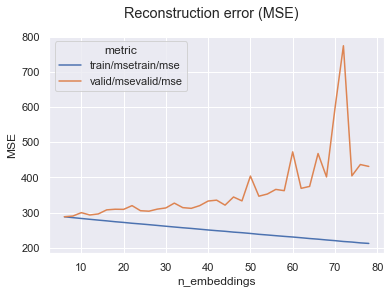

In [33]:

sns.lineplot(data=trace_df.query('n_embeddings < 80'), x='n_embeddings', y='value', hue='metric')
plt.suptitle('Reconstruction error (MSE)')
plt.ylabel('MSE')
plt.show()

## Load and prepare test-construct probabilities matrix

The following code creates also a scaled version of the probability matrix that tries to redistribute extreme values with a log transformation. Here is the transformation:

$$
\begin{align}
PROBS_{scaled} &= \log(PROBS) \\
PROBS_{scaled} &= PROBS_{scaled} - \min(PROBS_{scaled})
\end{align}
$$

The second formula forces the values to be positive, required by non-negative matrix factorization methods.


Co-occurrence probabilities show that some tasks and constructs do not appear with many other ones. To improve visualization and model fitting, we will remove those low-frequency ones. A rule of thumb would be discarding tests that appeared with only one construct, and construct that co-occurred with less than 3 tasks.

In [15]:
COOC = PUBMED.pipe(co_occurrence_matrix, groupby_category=True, probability=True).pivot(index='task', columns='construct',values='probability')

valid_constructs = COOC.columns[COOC.apply(lambda x: sum(x>0) > 5)].to_list()

# # remove low-appeared tests
valid_tasks = COOC[valid_constructs].index[COOC[valid_constructs].apply(lambda x: sum(x>0) > 3, axis=1)].to_list()

# # remove lowappeared constructs once again, to make sure removing tests would not make another construct invalid.
valid_constructs = COOC.columns[COOC.apply(lambda x: sum(x>0) > 5)].to_list()

# # filter
COOC = COOC.loc[valid_tasks, valid_constructs]

# # Also remove "Switching" because its corpus is the same as "Task Switching"
if 'Switching' in COOC.columns:
    COOC.drop(columns=['Switching'], inplace=True)

print(f'>>> Filtered low-appeared items. Analyzing {len(COOC.columns)} constructs and {len(COOC.index)} tasks.')

# # log-transform to scale extreme values of the probabilities
COOC_scaled = np.log(COOC).replace([-np.inf, np.inf], np.nan)
COOC_scaled = COOC_scaled - np.nanmin(COOC_scaled.values)

# COOC_scaled.to_csv(OUTPUT_FOLDER  / '98_test_construct_cooc_scaled.csv', index=True)

>>> Filtered low-appeared items. Analyzing 64 constructs and 80 tasks.


## Test-construct co-occurrence

As the initial step, the following code plots a simple heatmap that shows the `PROBS` matrix; it represents some kind of correlation between tests and constructs in the collected PubMed corpus.

**Note that, we assume appearance of an article in two corpora indicates correlation between the two.**

**Output image:** `1_task_construct_cooc_heatmap.png`

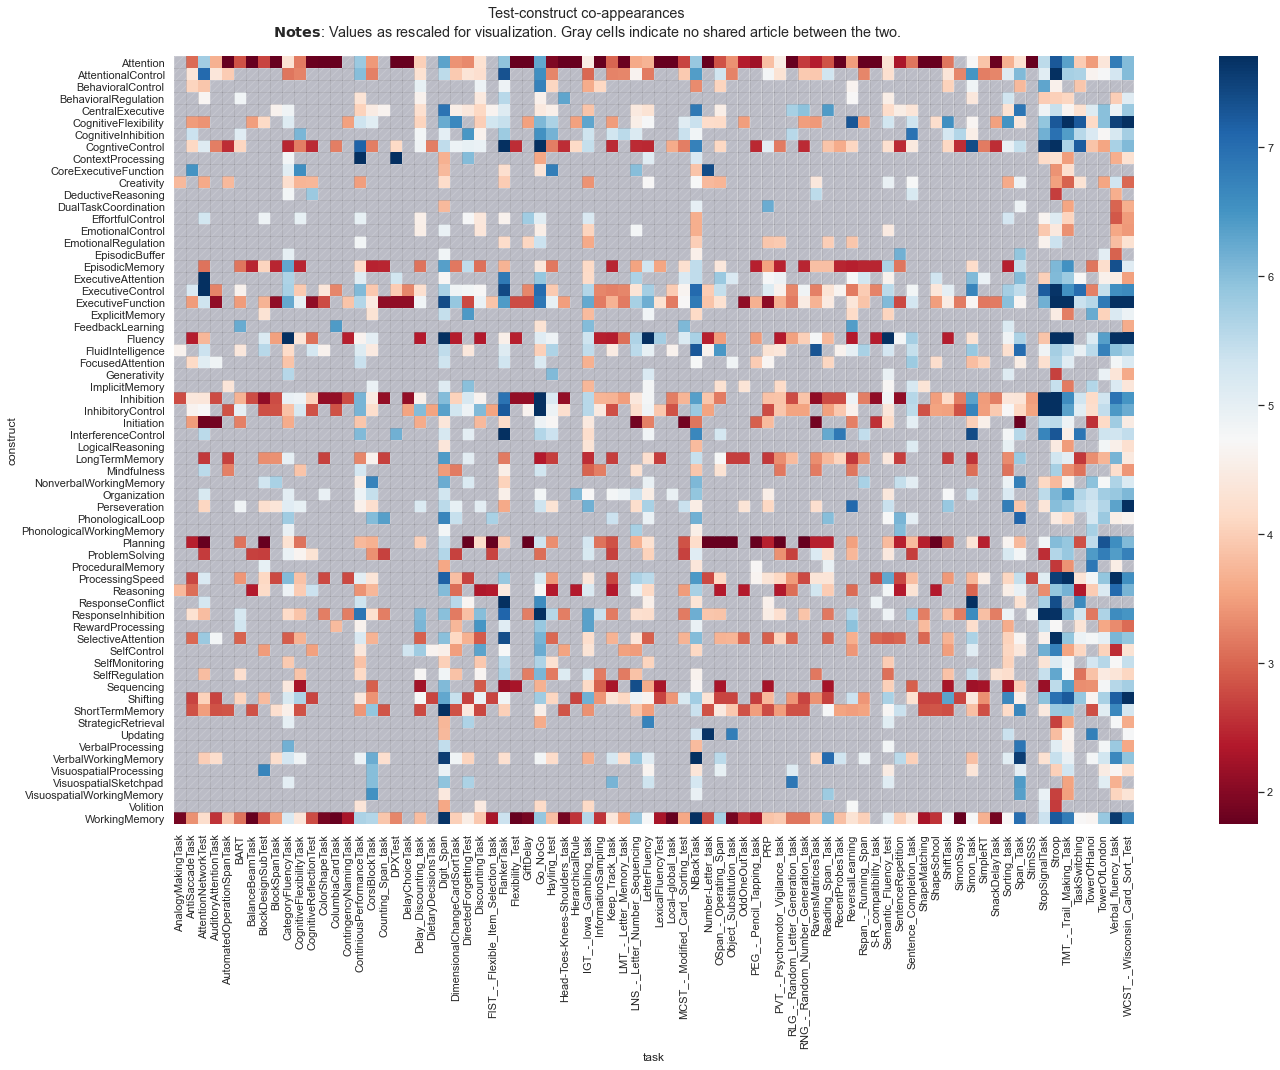

In [16]:
_, ax = plt.subplots(figsize=(25,15))
sns.heatmap(PROBS_scaled.T, square=True, robust=True, cmap='RdBu')
ax.pcolor(np.where(PROBS_scaled.T.isna(), 0, np.nan), hatch='///', alpha=.2, color='whitesmoke', fc='whitesmoke')
plt.suptitle('Task-Construct Co-occurrence \n'
             '$\\bf{Notes}$: Values as rescaled for visualization. Gray cells indicate no shared article between the two.', y=.99)
plt.tight_layout()
plt.savefig(OUTPUT_FOLDER / '1_task_construct_cooc_heatmap.png')
plt.show()

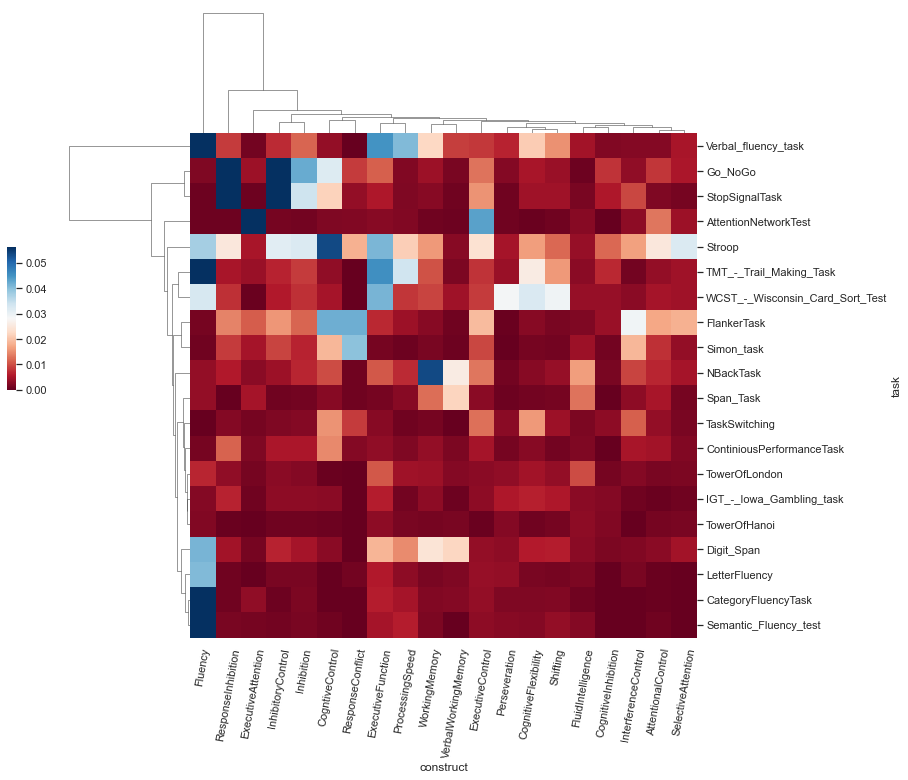

In [17]:
# COLLOQUIUM2021: most popular items to reduce the plot size

popular_constructs = PROBS.sum().sort_values(ascending=False)[:20].index
popular_tasks = PROBS.sum(axis=1).sort_values(ascending=False)[:20].index

PROBS_popular = PROBS.loc[popular_tasks, popular_constructs]
g = sns.clustermap(
    PROBS_popular.fillna(0), robust=True, cmap='RdBu',
    # row_cluster=False, col_cluster=False,
    figsize=(12,11),
    # metric='correlation',
    cbar_pos=(-.05, 0.5, .01, .18), mask=PROBS_popular.isna())
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=80, ha='center')
plt.savefig(OUTPUT_FOLDER / '1_popular_task_construct_cooc_heatmap.png')
plt.show()

The above heat map is not very informative because tests and constructs live in two different space. One way to combine them into a shared latent space is factorizing the test-construct co-occurrence matrix.

## Matrix factorization

There are a variety of methods to factorize a matrix, including methods to fill up missing values or approximate using neural networks. In our case, we have access to the full matrix, so we don't need those kinds of techniques and simple factorization like Non-Negative Factorization (NMF) would suffice. We hence only optimize the hyper-parameter (`n_components`) by minimizing the MSE cost of the approximation. Given labels co-occurrence matrix, $X_c$, The following equation holds:


$$
X_{m \times c} \approx M_{m \times n} \times C^T_{n \times c}
$$


where $X_c$ is the scaled co-occurrence probability matrix, M is the tests embedding matrix, and C is the constructs embedding matrix.

  0%|          | 0/64 [00:00<?, ?it/s]/Users/morteza/miniconda3/envs/py3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 100000 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
100%|██████████| 64/64 [00:16<00:00,  3.84it/s]


Reached minimum MSE with embedding dimension of 64.


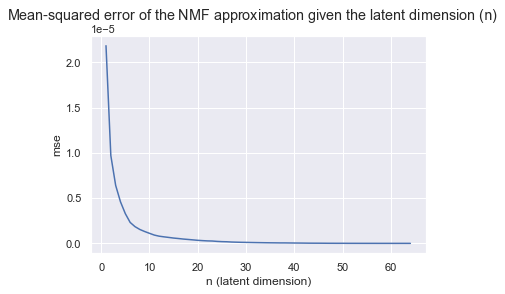

In [19]:
# for brevity, immutable data, and matching the formulas in the text.
X = PROBS.fillna(0).copy()

# upon completion, costs will be a data frame with two columns: embedding_dim and mse.
costs = []

MAX_EMBEDDING_DIM = np.min(X.shape) + 1

for embedding_dim in tqdm(range(1, MAX_EMBEDDING_DIM)):
    model = NMF(n_components=embedding_dim, init='nndsvda', max_iter=100000)
    M = model.fit_transform(X)
    C = model.components_
    mse = (((M@C - X).values)**2).mean()
    costs.append((embedding_dim, mse))

costs = pd.DataFrame(costs, columns=['embedding_dim', 'mse'])

# report best fitted param
print(f'Reached minimum MSE with embedding dimension of '
      f'{costs.query("mse == mse.min()")["embedding_dim"].values[0]}.')

# now plot the model fitting MSE against the model parameter (n_components)
sns.lineplot(data=costs, x='embedding_dim', y='mse')
plt.xlabel('n (latent dimension)')
plt.suptitle('Mean-squared error of the NMF approximation given the latent dimension ($\\mathtt{n}$)')
plt.savefig(OUTPUT_FOLDER / '2_nmf_fitting_mse.png')
plt.show()


## Reducing latent model complexity

The plot above shows that fitness of the model is monotonically increasing by incorperating more latent dimensions, hence, the original data would be the best fit! Despite this, a desired embedding dimension would be less complex that the original data, i.e., it compresses the data.

An arbitrary compressed dimension could be the point at which MSE reaches the 5% of the minimum possible MSE (or any other threshold, $\alpha$). In other words, it's the minimum number of embedding dimensions that produces an approximation within 5% of the minimum possibble MSE. The $n$ in following formula represents this compressed dimension:

$$
\mathbf{MSE}_n(X-M \times C^T) < \alpha \times \min(\mathbf{MSE}_{1 \ldotp\ldotp \min(m,c)}).
$$


Or, more precisely, the following reflects the implementation:


$$
\operatorname*{f}(n) = \alpha \times \min(\mathbf{MSE}_{1 \ldotp\ldotp \min(m,c)}) - \mathbf{MSE}_n(X-M \times C^T) \\
\operatorname*{argmin}_n(f(n)), f>0
$$


where $\mathbf{MSE}_m$ is the mean-squared error for $m$ embedding dimensions and $\alpha$ is the threshold (here, 5%).

In [20]:
ALPHA = 0.05  # MSE decision threshold.

embedding_dim = costs.query('mse < mse.min() + @ALPHA * (mse.max() - mse.min())')['embedding_dim'].min()

print(f'Embedding dimension (within {ALPHA*100:.0f}% of the minimum MSE): {embedding_dim}')

# now fit the final model with the chosen hyperparameter
model = NMF(n_components=embedding_dim, init='nndsvda', max_iter=100000)
M = model.fit_transform(X)
C = model.components_

# print(M.shape, C.shape)

M = pd.DataFrame(M, index=X.index)
C = pd.DataFrame(C.T, index=X.columns)

Embedding dimension (within 5% of the minimum MSE): 11


Now we have two embeddings, $M$ for tasks, and $C$ for constructs. But before further analysis, let's try another method that could give us an appropriate embedding dimension. 

## Cross validation to control model complexity
The complexity reduction method explained above, although being practical, is not the only way to find a proper model parameter, i.e., embedding dimension. We can also use cross validation to find the model parameter by which the model does not overfit or underfit given a held-out subset of data. Below is the implementation of this technique; only for demonstration purposes. Results do not seem very useful as both test and train MSEs are monotonically decreasing.

**Note:** to avoid naming conflict with the term *cognitive tests*, CV test set will be called validation set (or valid).

**TODO:** [https://gitlab.uni.lu/xcit/efo/cognitive-tests-text-analysis/-/issues/32]

  0%|          | 0/17 [00:00<?, ?it/s]/Users/morteza/miniconda3/envs/py3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 10000 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
/Users/morteza/miniconda3/envs/py3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 10000 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
/Users/morteza/miniconda3/envs/py3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 10000 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
/Users/morteza/miniconda3/envs/py3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterat

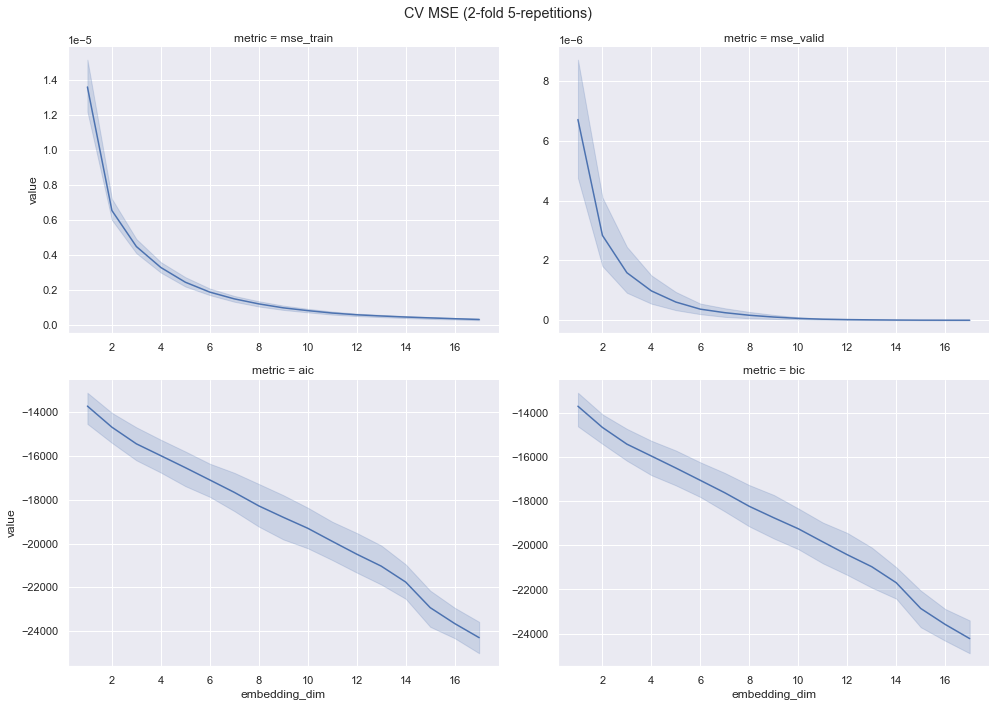

In [36]:
# K-Fold CV to reduce model complexity

from sklearn.model_selection import KFold, RepeatedKFold

# create k-fold repeated cross validation sets (n repetitions; overall k*n sets)
cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=0)
cv_splits = list(cv.split(X))

# find the minimum number of rows in test/train sets and use it as the upper bound for the fitting
MAX_EMBEDDING_DIM = min([len(s) for c in cv_splits for s in c])

# CV model fitting trace
trace = []

for dim in tqdm(range(1, MAX_EMBEDDING_DIM + 1)):
    # now loop over the train/test pair and fit the model parameter to the data
    for i, (train_index, valid_index) in enumerate(cv_splits):
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]

        model = NMF(n_components=dim, init='nndsvda', max_iter=10000)
        _M = model.fit_transform(X_train)
        _C = model.components_
        mse_train = (((_M@_C - X_train).values)**2).mean()

        # now evaluate the test set
        model = NMF(n_components=dim, init='nndsvda', max_iter=10000)
        _M = model.fit_transform(X_valid)
        _C = model.components_
        mse_valid = (((_M@_C - X_valid).values)**2).mean()

        # AIC and BIC
        n_data = np.dot(*X_valid.shape)
        n_params = dim
        aic_valid = n_data * np.log(mse_valid) + 2 * n_params
        bic_valid = n_data * np.log(mse_valid) + n_params * np.log(n_data)
        
        trace.append([dim, mse_train, mse_valid, aic_valid, bic_valid])
        # DEBUG print(f'MSE: train={mse_train:.2}, validation={mse_valid:.2}', file=sys.stderr)

trace = pd.DataFrame(trace, columns=['embedding_dim','mse_train','mse_valid', 'aic', 'bic'])

# now plot all the model evaluation metrics
g = sns.FacetGrid(
    data=trace.melt(value_vars=['mse_train','mse_valid','aic', 'bic'], id_vars=['embedding_dim'], var_name='metric'),
    col='metric', col_wrap=2, height=5, aspect=1.4,
    sharey=False, sharex=False,
)
g.map(sns.lineplot, 'embedding_dim', 'value')
plt.suptitle('CV MSE (2-fold 5-repetitions)')
plt.tight_layout()
plt.show()

Leaving the CV results aside, let's get back to the embedding dimension from the first hack, and move on to the visualization. We may later improve and use the CV results.

## Visualizing the latent space

Now we can plot the latent space that we just created. Easiest plots would show loadings of the cognitive tests and constructs on latent dimensions. 

**Outputs:**
- `3_tests_embedding.png`: Cognitive tests embedding
- `4_constructs_embedding.png`: Constructs embedding

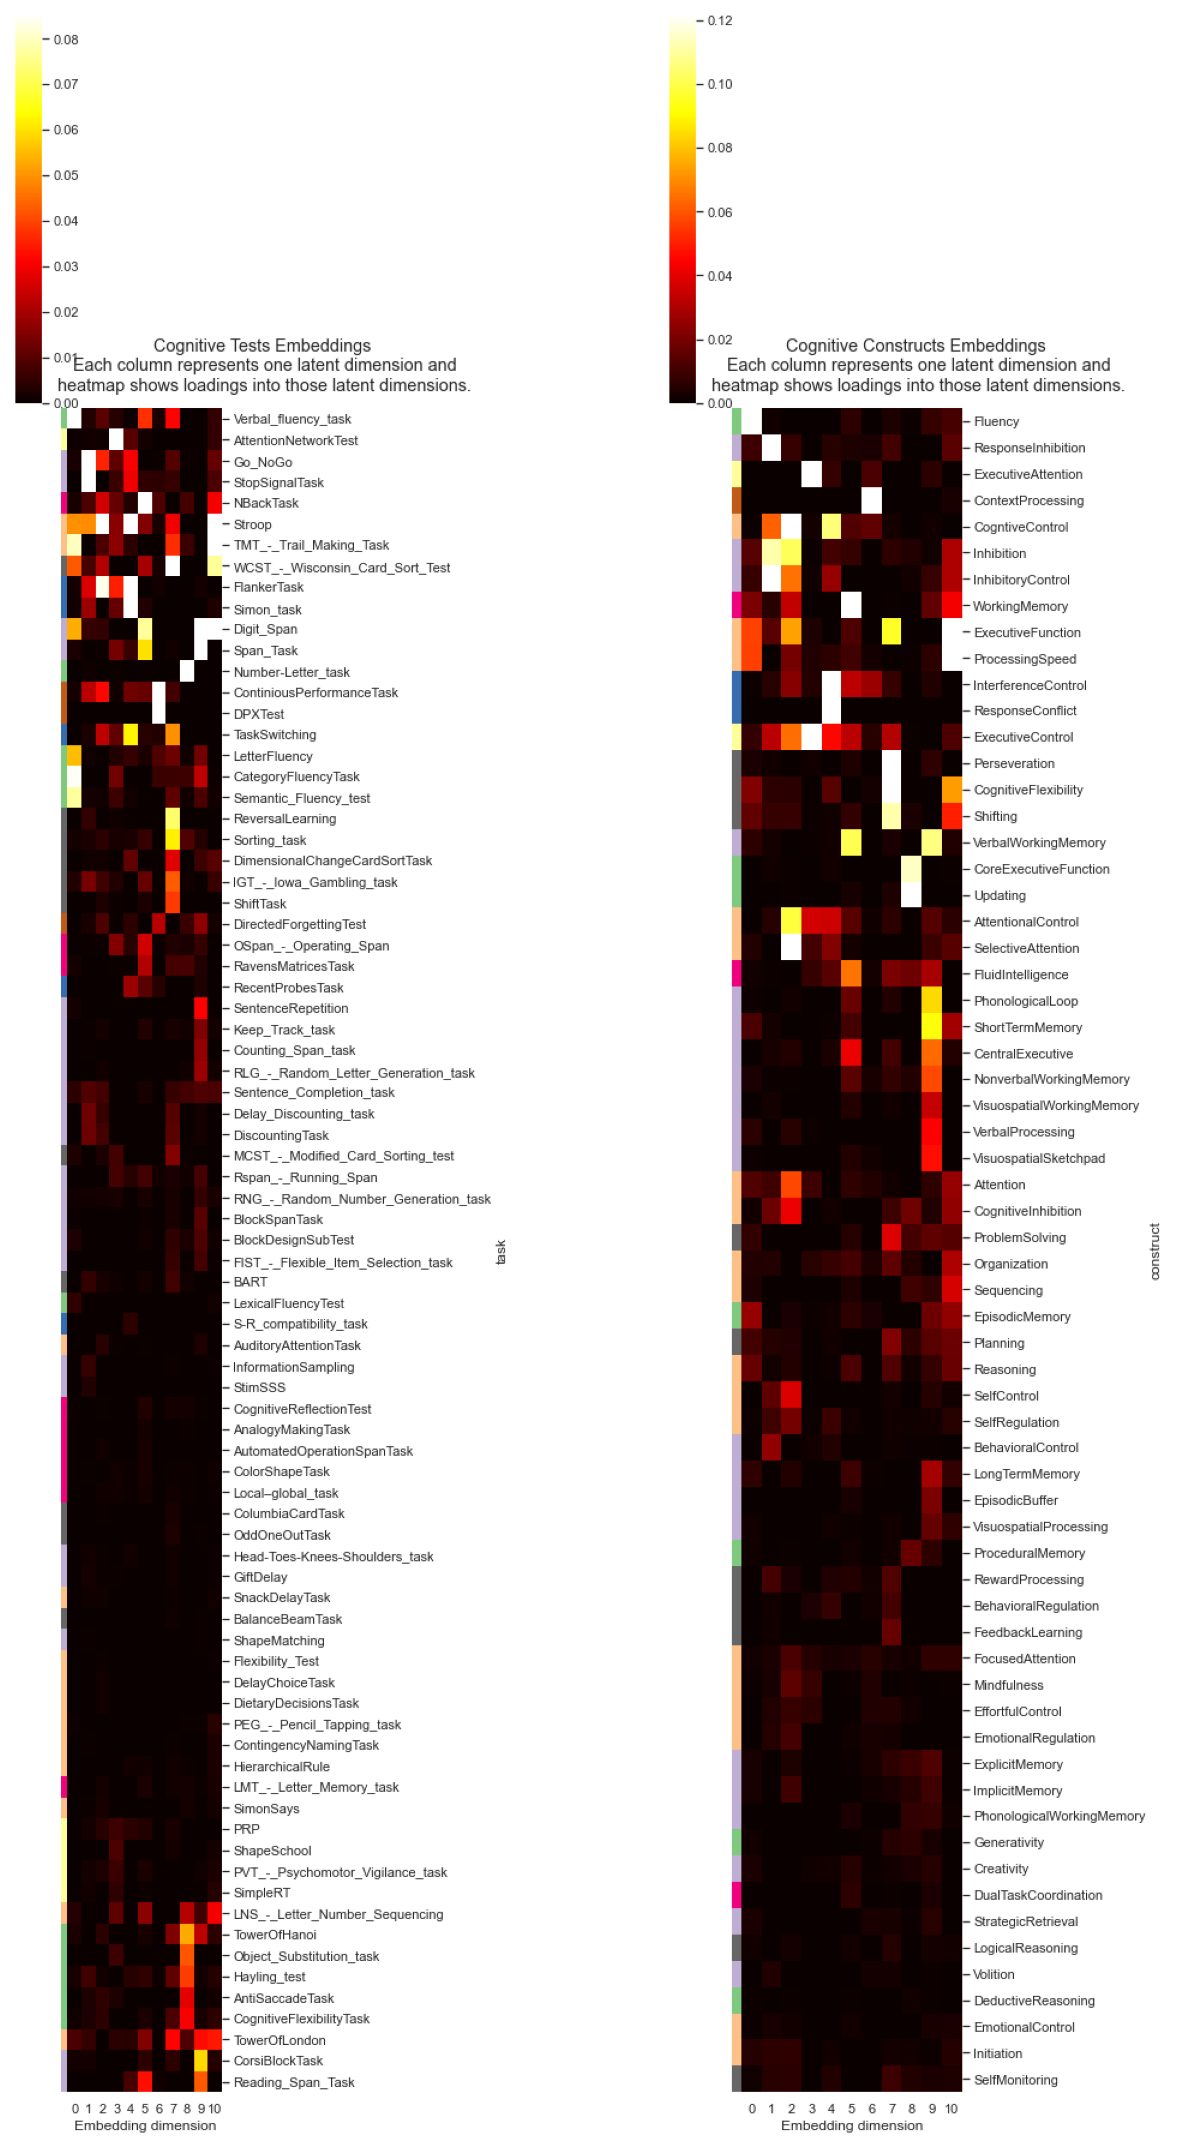

In [21]:
from matplotlib.image import imread

# C['embedding_cluster'] = C.iloc[:, :embedding_dim].apply(np.argmax,axis=1)
# M['embedding_cluster'] = M.iloc[:, :embedding_dim].apply(np.argmax,axis=1)

def plot_embedding_clustermap(embedding_mat, title, filename, figsize=(6,25)):

    # simple clustering to group entities in the latent space
    clusters = embedding_mat.iloc[:, :embedding_dim].apply(np.argmax,axis=1)

    _palette = dict(zip(np.unique(clusters), sns.color_palette('Accent', len(clusters))))
    _cluster_colors = [_palette[c] for c in clusters]

    g = sns.clustermap(embedding_mat,
                       col_cluster=False,
                       figsize=figsize,
                       row_colors=_cluster_colors,
                       robust=True,
                       cmap='hot',
                       )
    g.ax_heatmap.set(xlabel='Embedding dimension')
    g.ax_row_dendrogram.set_visible(False)
    g.ax_col_dendrogram.set_visible(False)
    g.fig.suptitle(f'{title} \n '
                'Each column represents one latent dimension and \n'
                'heatmap shows loadings into those latent dimensions.',
                y=.83)

    g.savefig(OUTPUT_FOLDER / filename)
    plt.close(g.fig)

plot_embedding_clustermap(M, 'Cognitive Tests Embeddings', '3_tests_embedding.png')
plot_embedding_clustermap(C, 'Cognitive Constructs Embeddings', '4_constructs_embedding.png', figsize=(6,25))

_, axes = plt.subplots(1, 2, figsize=(20, 30))
axes[0].imshow(imread(OUTPUT_FOLDER / '3_tests_embedding.png'))
axes[1].imshow(imread(OUTPUT_FOLDER / '4_constructs_embedding.png'))

[ax.set_axis_off() for ax in axes.ravel()]
plt.tight_layout()
plt.show()


We can cluster tests and connstructs in the latent space using different methods. Below, we are clustering them according to the embedding dimension that they load maximally into. These clusters were, in fact, shown in the narrow color bars on left side of the above heatmaps.

### Output

- This piece clusters tests and constructs in a way that clusters could overlap. It produces two data frames, for tests or constructs separately, in that each column is a cluster group. For example, column `cluster_1` shows which cluster has the first priority, column `cluster_2` shows which cluster has the second priority, so on and so forth.
- The second outputs is the `M_communities` and `C_communities`, that are overlapping clusters of similar tests and similar constructs.

In [22]:
# 1. clustering
# just sort embedding values and assign cluster to the dim with maximal loading
C_clusters = C.iloc[:, :embedding_dim].apply(lambda x: np.argsort(x)[::-1].to_list(), axis=1)
M_clusters = M.iloc[:, :embedding_dim].apply(lambda x: np.argsort(x)[::-1], axis=1)

# or uncomment the following 3 lines to use DBSCAN instead of maximum dim
# from sklearn.cluster import DBSCAN
# C_clusters = DBSCAN(eps=.2, min_samples=1).fit(C).labels_
# M_clusters = DBSCAN(eps=.2, min_samples=1).fit(M).labels_

# 2. communinties

def find_communities(embedding_loadings):
    """Find communities of noddes given loadings onto embedding dimensions.

    See texts for the arbitrary assumptions.
    """

    # discard loadings below this threshold
    _EMBEDDING_LOADING_THRESHOLD = 0.001

    _e = embedding_loadings.copy()
    _e[_e < _EMBEDDING_LOADING_THRESHOLD] = 0.0
    
    nonzero_cnt = np.count_nonzero(_e)
    
    # pick the largest non-zero _cnt dimensions
    _e = np.argsort(_e)[::-1].to_list()[:nonzero_cnt]
    return _e

C_comm = C.iloc[:, :embedding_dim].apply(find_communities, axis=1)
M_comm = M.iloc[:, :embedding_dim].apply(find_communities, axis=1)


In [ ]:

# Q: how much is the graph reliable?

# # csv
# node, cluster_1, cluster_2, cluster_3
# 1, 1, 2, 3
# 2, 2, 1, 3

# from Pedro CARDOSO LEITE to Everyone:    2:27  PM
# [n=10]; ranks = [r1, r2, ...]
# from Pedro CARDOSO LEITE to Everyone:    2:27  PM
# [n=20]; ranks_20 = [r1, r2, ...]
# from Pedro CARDOSO LEITE to Everyone:    2:27  PM
# mean(ranks10==ranks20)
# from Pedro CARDOSO LEITE to Everyone:    2:28  PM
# plot percent match as a function of n

### DEBUG

** Ignore this section and move on to the next part!**

The labels co-occurrence matrix contains colinear columns and rows. Here, we are going to check matrix ranks and then find those colinear rows and columns. 


In [39]:
# check matrix rank
PROBS_rank = np.linalg.matrix_rank(PROBS)
print(f'dim: {PROBS.shape},', f'rank: {PROBS_rank}')

# check colinear columns
import sympy

_, colinear_tests = sympy.Matrix(PROBS).T.rref()
_, colinear_constructs = sympy.Matrix(PROBS).rref()

colinear_tests = set(range(PROBS.shape[0])) - set(colinear_tests)
colinear_constructs = set(range(PROBS.shape[1])) - set(colinear_constructs)

print('colinear constructs: ', PROBS.columns[list(colinear_constructs)])
print('colinear tests; ', PROBS.index[list(colinear_tests)])

dim: (88, 64), rank: 64
colinear constructs:  Index([], dtype='object', name='construct')
colinear tests;  Index(['ReverseCategorization', 'Rspan_-_Running_Span',
       'S-R_compatibility_task', 'SelfControlScheduleTask',
       'Semantic_Fluency_test', 'SentenceRepetition',
       'Sentence_Completion_task', 'ShapeMatching', 'ShapeSchool', 'ShiftTask',
       'SimonSays', 'Simon_task', 'SimpleRT', 'SnackDelayTask', 'Sorting_task',
       'Span_Task', 'StopSignalTask', 'Stroop', 'TMT_-_Trail_Making_Task',
       'TaskSwitching', 'TowerOfHanoi', 'TowerOfLondon', 'Verbal_fluency_task',
       'WCST_-_Wisconsin_Card_Sort_Test'],
      dtype='object', name='task')


## Latent graphs

The following part visualizes the tests and constructs in their latent spaces; this time in a graph, where each node is a test or construct and weighted edges show the distance between a pair of tests or constructs in the latent space. Distance between two nodes are also representative of the latent distance between respective vectors; More similar they are, closer they get.

**Inputs:** $M$ and $C$ embeddings.
**Outputs:**  ...

As the first step, let's calculate the latent distance between each pair of tests and each pair of constructs. The easy way to plot and diagnose the similarity matrices would be a heat map.

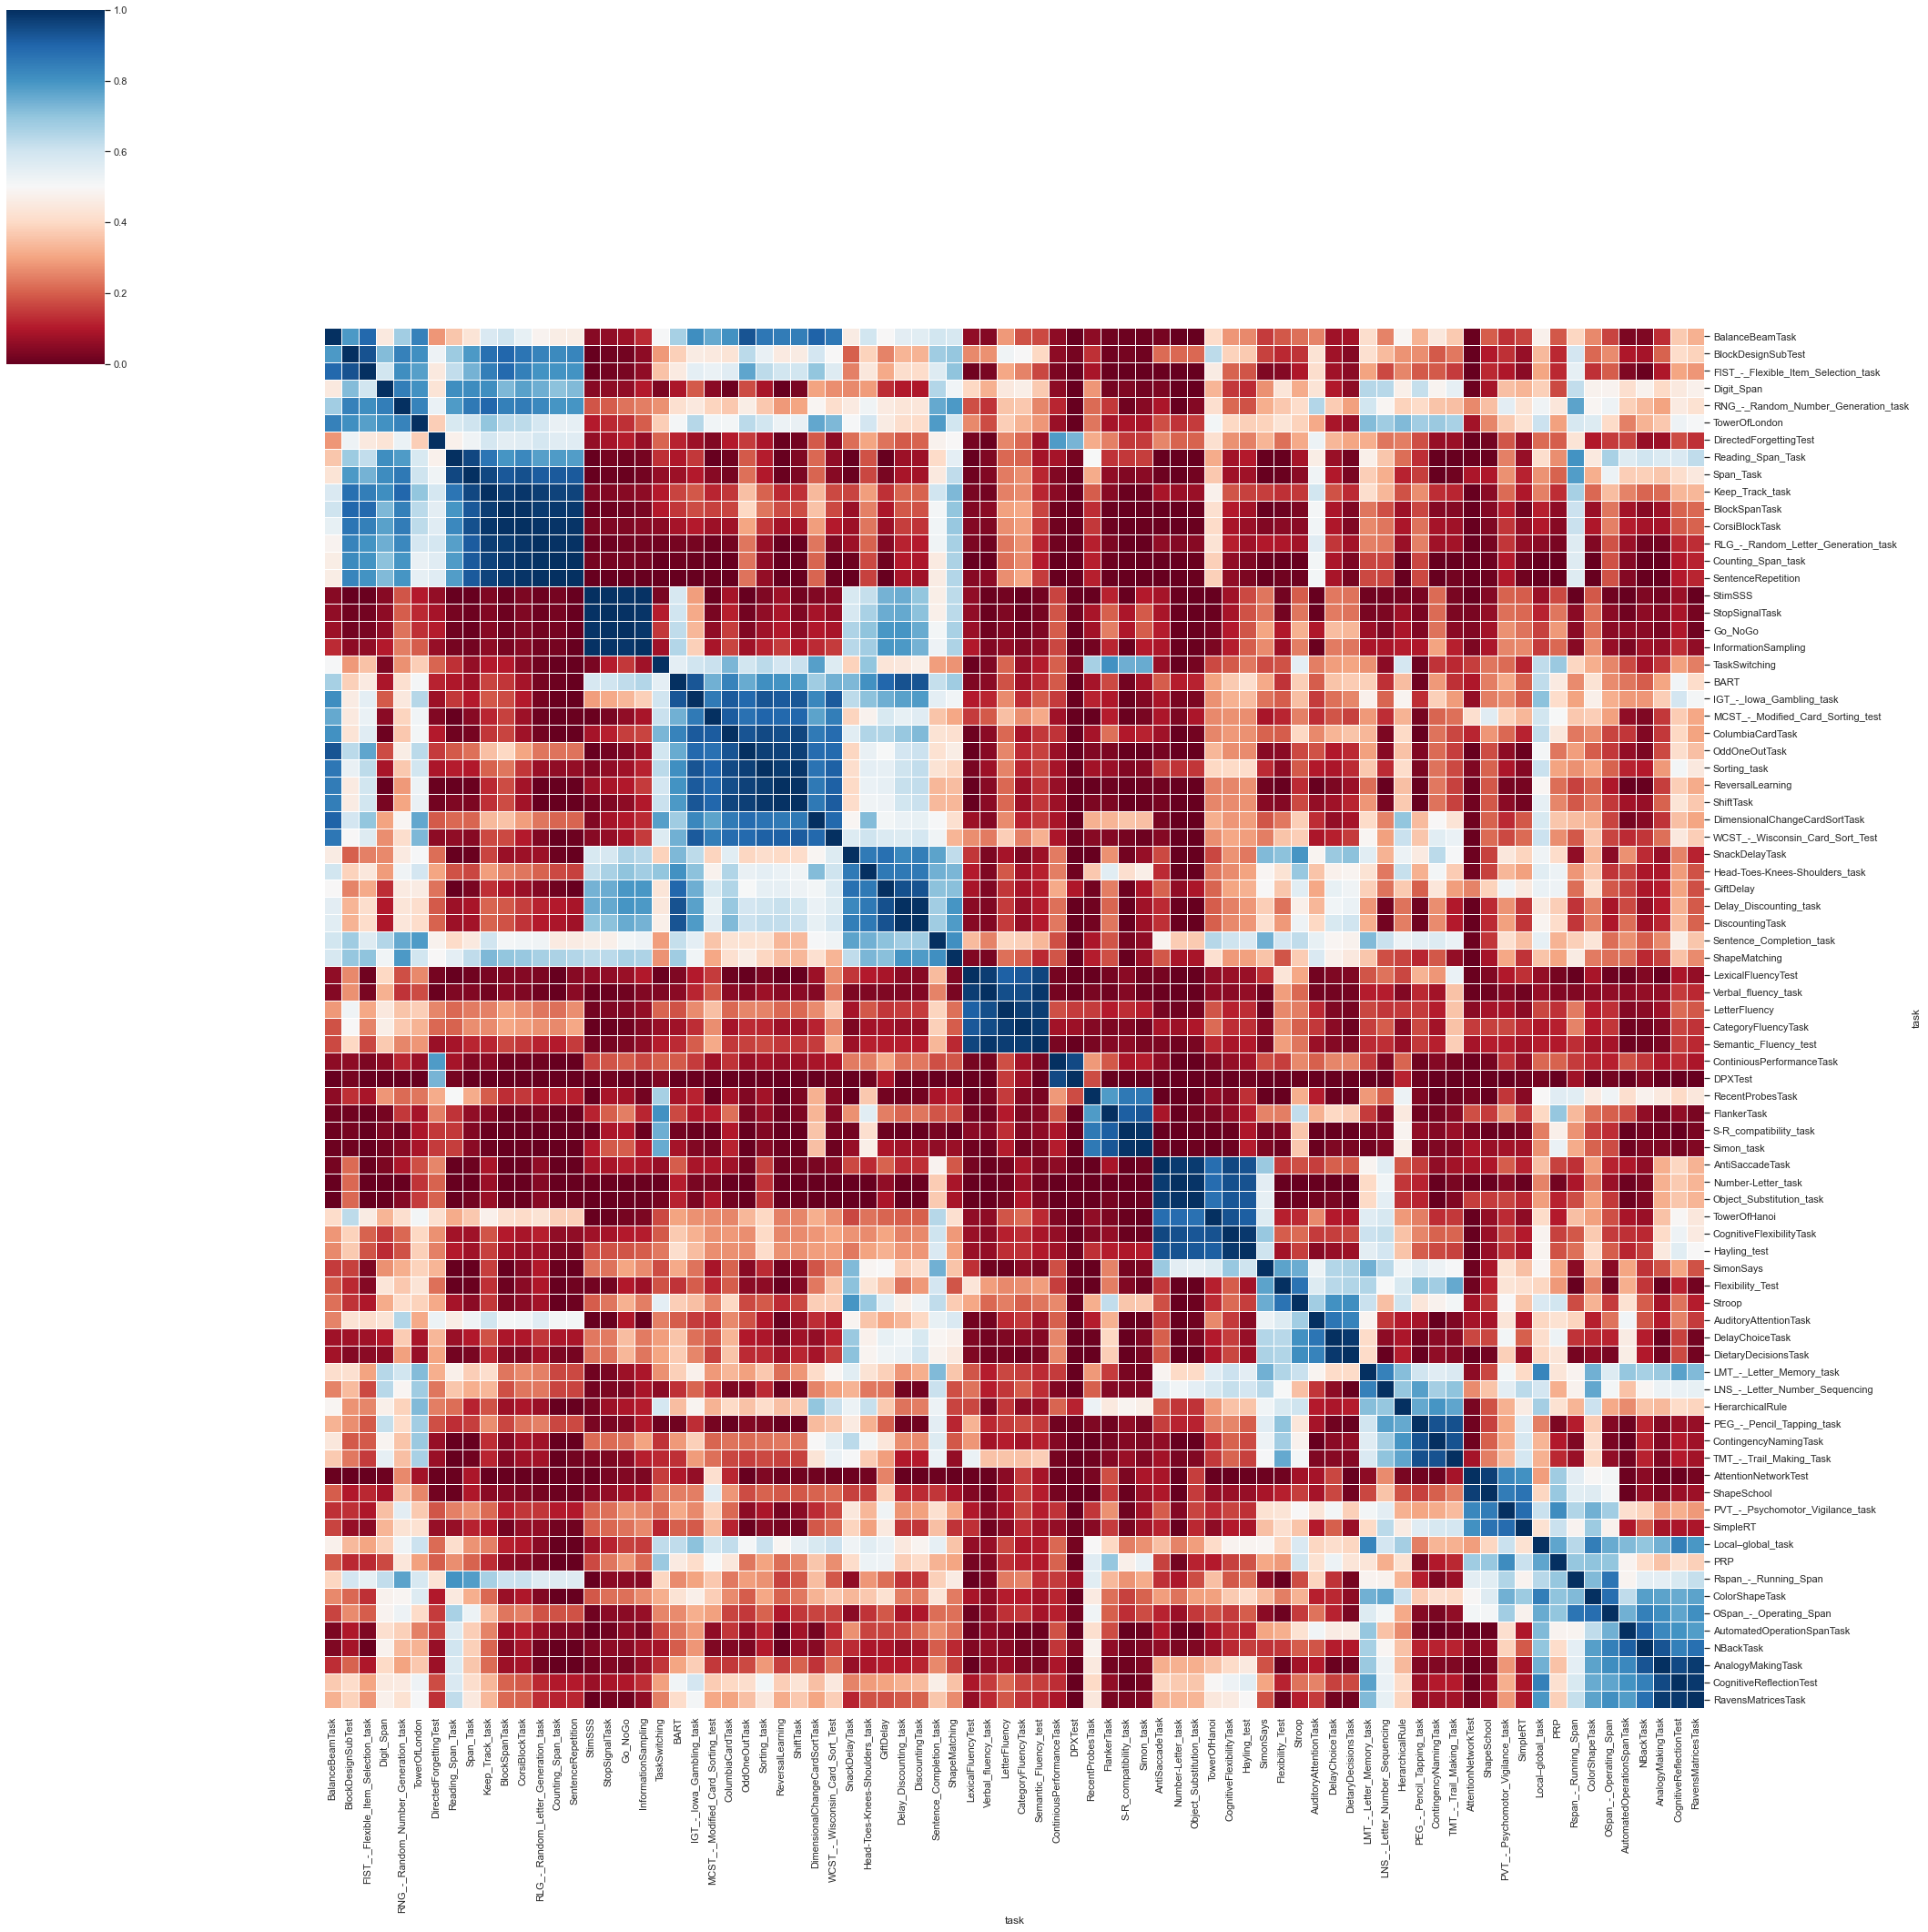

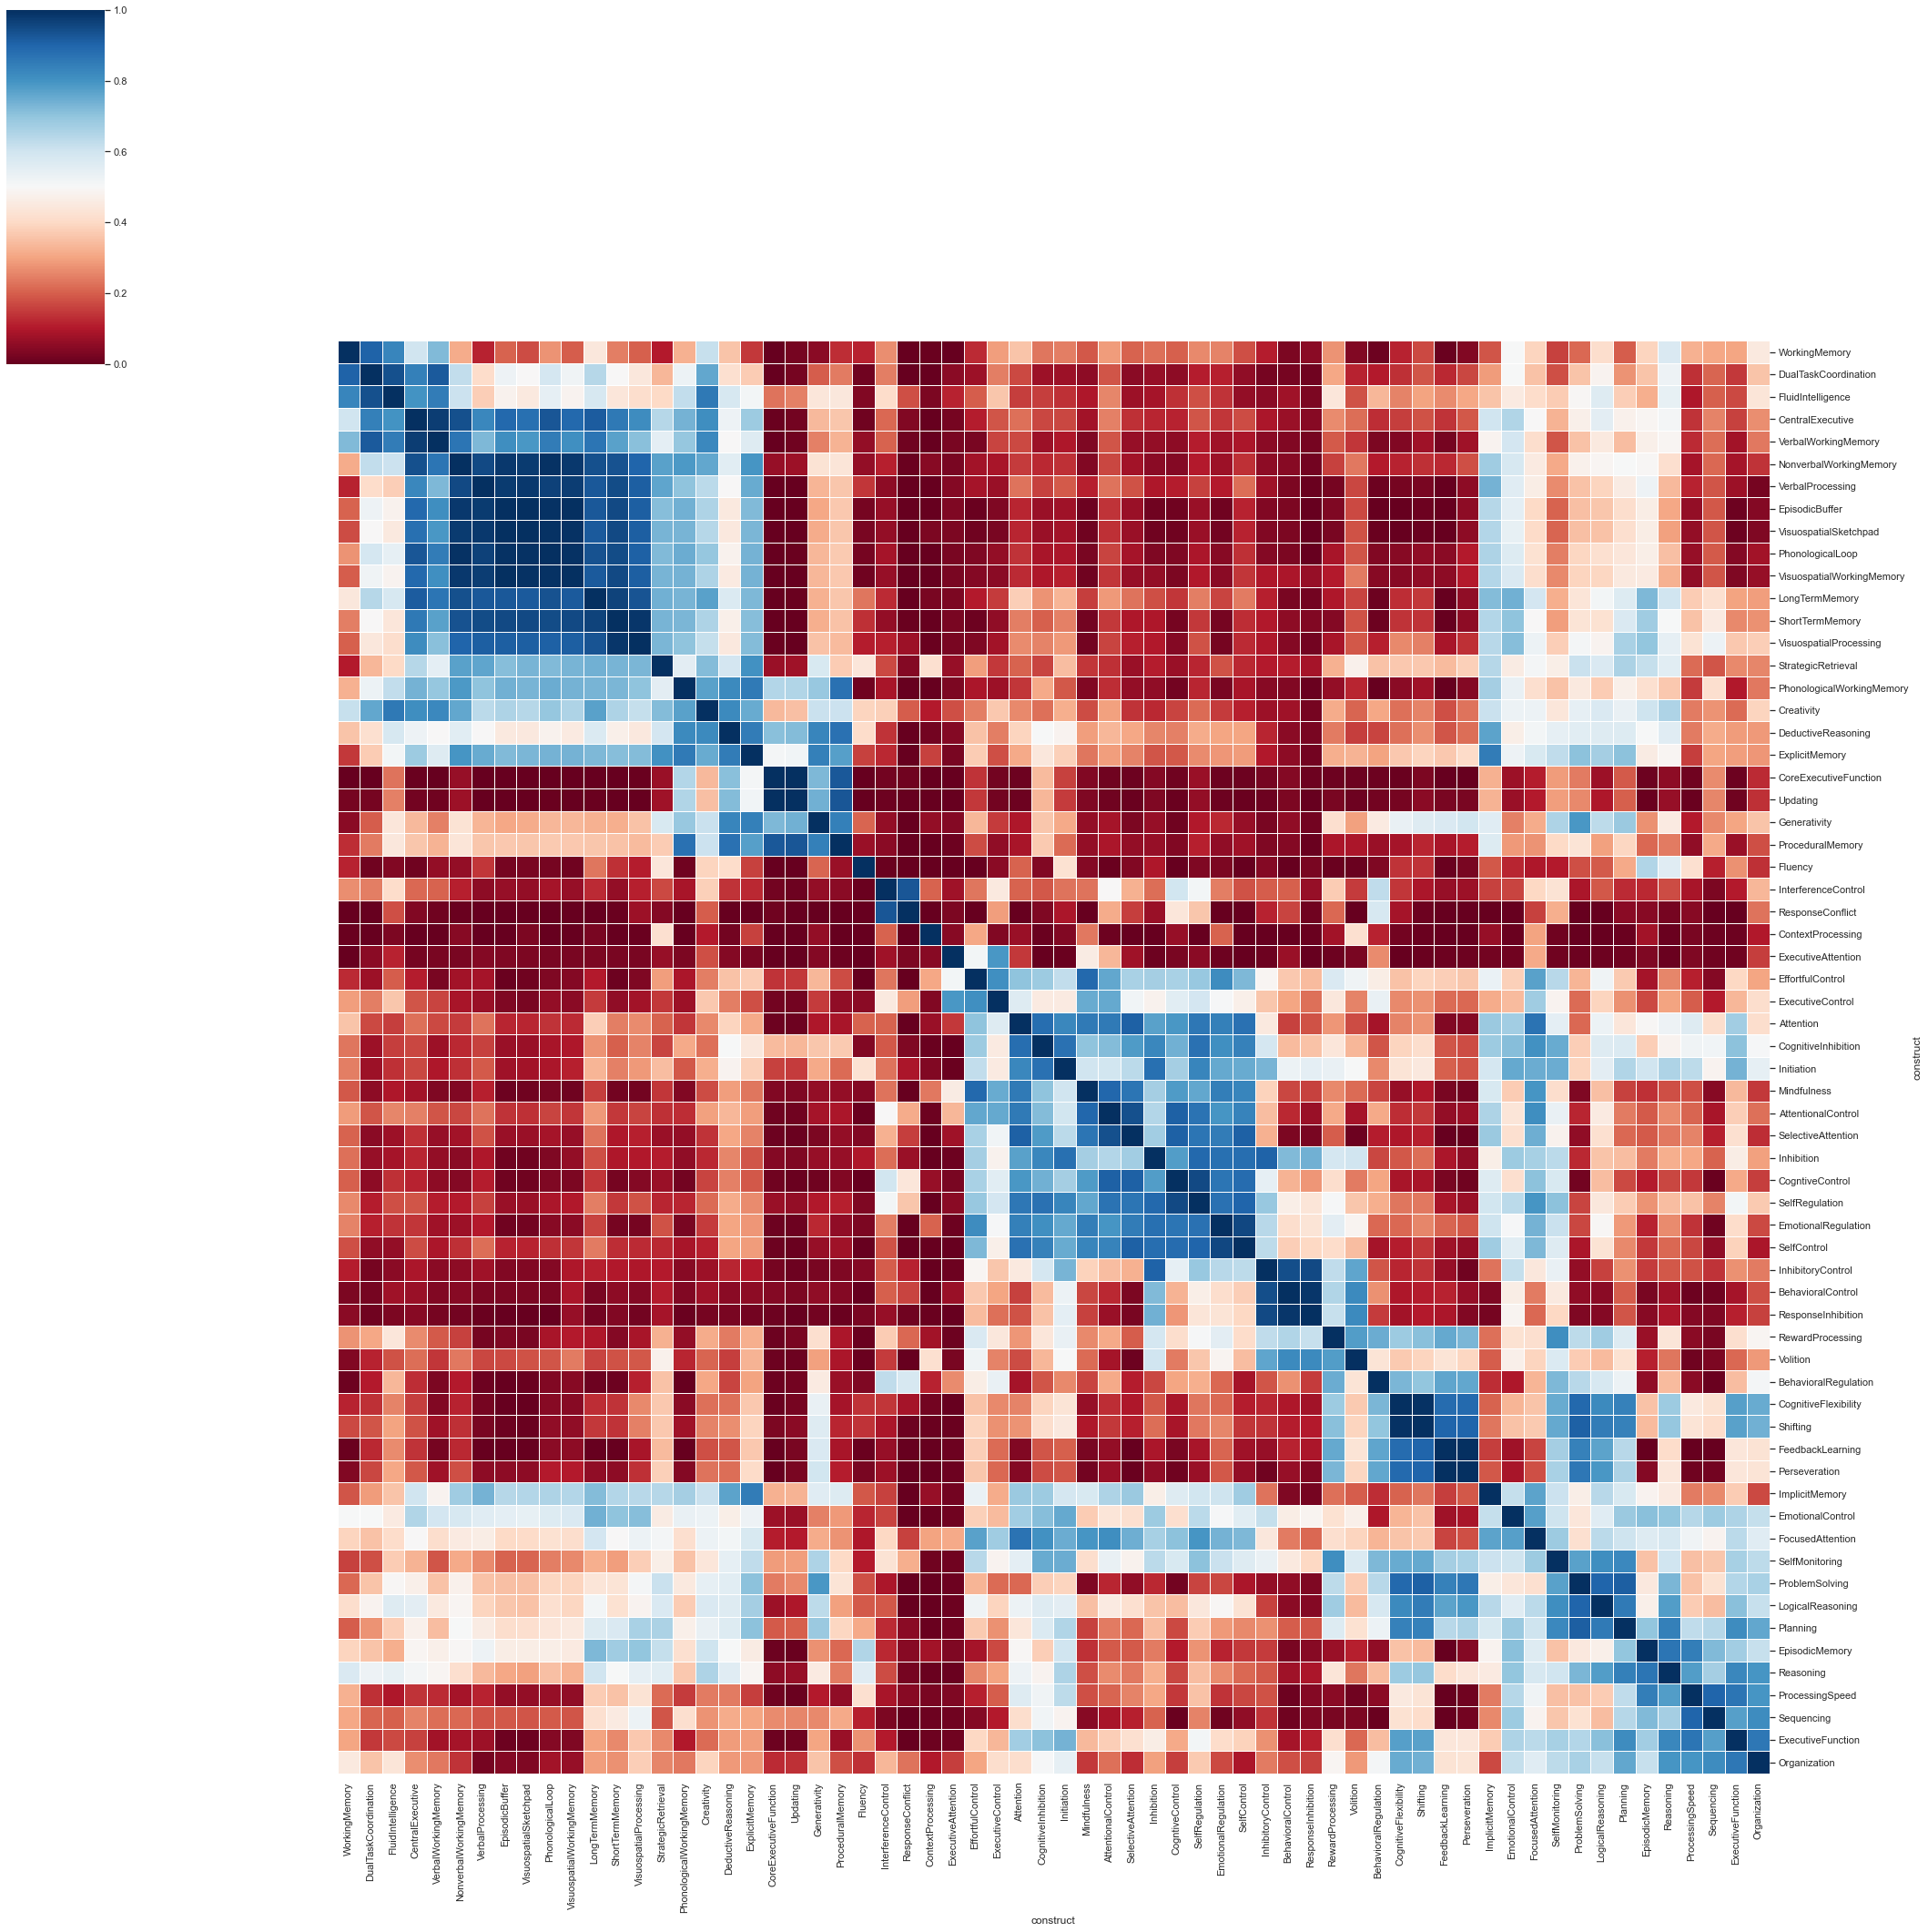

In [23]:
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity  # DEBUG: euclidean_distances

# # cognitive tests similarity given constructs
M_sim = pd.DataFrame(cosine_similarity(M), columns=M.index, index=M.index)
g = sns.clustermap(M_sim, lw=1, cmap='RdBu', figsize=(30,30))
g.ax_row_dendrogram.set_visible(False)
g.ax_col_dendrogram.set_visible(False)
plt.show()

# # cognitive constructs similarity given test
C_sim = pd.DataFrame(cosine_similarity(C), columns=C.index, index=C.index)
g = sns.clustermap(C_sim, lw=1, cmap='RdBu', figsize=(30,30))
g.ax_row_dendrogram.set_visible(False)
g.ax_col_dendrogram.set_visible(False)
plt.show()

Now we plot the latent graphs of the tests and constructs.

**Outputs:** 
- `5_pyvis_map_tests_embedding.html`: interactive graphs of the test embedding. Open it up with a browser.
- `6_pyvis_map_constructs_embedding.html`: interactive graph of the constructs embedding. Open it up with a browser.
- Inline graphs, produced by NetworkX, are solely there for debugging purposes. Ignore them!

In [34]:
# visualization parameters for PyViz. Use nt.show_buttons(...) to modify.
pyvis_options = """
var options = {
  "nodes": {
    "color": {
      "border": "white",
      "background": "lightblue",
      "highlight": {
        "border": "mediumpurple",
        "background": "mediumpurple"
      }
    }
  },
  "edges": {
    "arrows": {
      "to": {
        "enabled": false
      },
      "from": {
        "enabled": false
      }
    },
    "arrowStrikethrough": false,
    "color": {
      "color": "#dcdcdc88",
      "highlight": "mediumpurple",
      "inherit": false
    },
    "smooth": {
      "type": "continuous",
      "forceDirection": "none"
    }
  }
}
"""

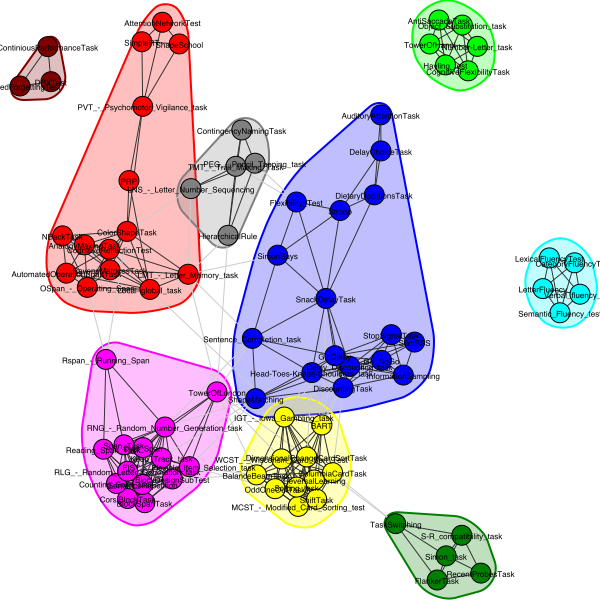

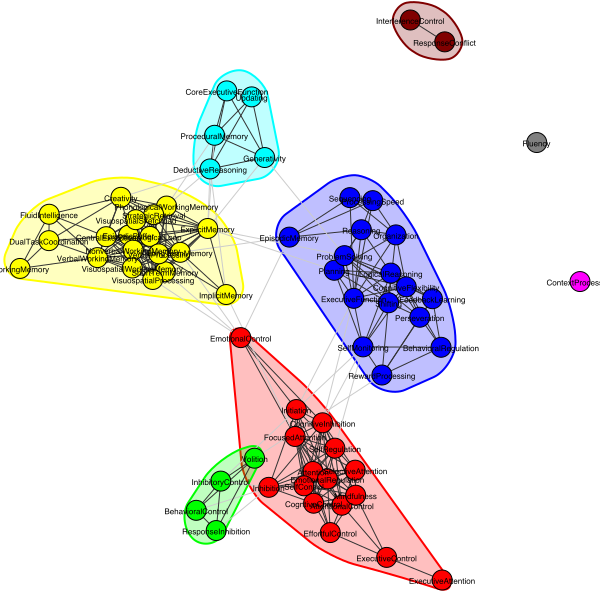

In [35]:
import random

def plot_latent_similarity_ig(embedding, title, edge_threshold=.7):
    import igraph as ig
    from IPython.display import display

    _sim = cosine_similarity(embedding)

    g = ig.Graph.Weighted_Adjacency(_sim, mode='upper', loops=False)
    g.vs['label'] = embedding.index
    g.es.select(weight_lt=edge_threshold).delete()

    comms = g.community_multilevel()

    g_plot = ig.plot(
        comms,
        target=f'{OUTPUT_FOLDER}/{title}.png',
        dpi=300,
        vertex_label_size=8, mark_groups=True, edge_curved=False)
    
    display(g_plot)


def plot_latent_similarity_nx(embedding, title, edge_threshold=.7):

    _sim = cosine_similarity(embedding)

    g = nx.from_numpy_matrix(_sim)

    # node labels
    node_labels = {i:t for i,t in enumerate(embedding.index)}
    nx.set_node_attributes(g, node_labels, 'label')

    # edges
    edges = [(u, v) for (u, v, d) in g.edges(data=True) if d['weight'] > edge_threshold]
    edge_weights = [d['weight'] for (u, v, d) in g.edges(data=True) if d['weight'] > edge_threshold]

    # layout
    pos = nx.spring_layout(g, k=0.1)

    plt.subplots(figsize=(10,10))

    # TODO node_sizes = tas/construct corpus_size
    nx.draw_networkx_nodes(g, pos, node_size=100)
    nx.draw_networkx_edges(g, pos, edgelist=edges, width=edge_weights, edge_color='r')
    nx.draw_networkx_labels(g, pos, node_labels, alpha=.5)

    plt.show()


def plot_latent_similarity_nt(embedding, title, edge_threshold=.7):
    """Interactive plot."""
    from pyvis.network import Network
    import igraph as ig

    _sim = cosine_similarity(embedding)

    g = ig.Graph.Weighted_Adjacency(_sim, mode='upper', loops=False)
    g.vs['label'] = embedding.index
    g.es.select(weight_lt=edge_threshold).delete()

    nt = Network(height='1000px', width='1000px', directed=False, notebook=False, heading=title)
    nt.from_nx(g.to_networkx())

    
    # DEBUG
    nt.set_options(pyvis_options)
    # nt.show_buttons(filter_=['physics'])

    nt.show(f'{OUTPUT_FOLDER}/{title}.html')


# the actual call to create the graph
# plot_latent_similarity_nx(M, '5_tests_similarity_map')
# plot_latent_similarity_nx(C, '6_constructs_similarity_map')

plot_latent_similarity_ig(M, '5_tests_similarity_map')
plot_latent_similarity_ig(C, '6_constructs_similarity_map')

plot_latent_similarity_nt(M, '5_tests_similarity_map')
plot_latent_similarity_nt(C, '6_constructs_similarity_map')

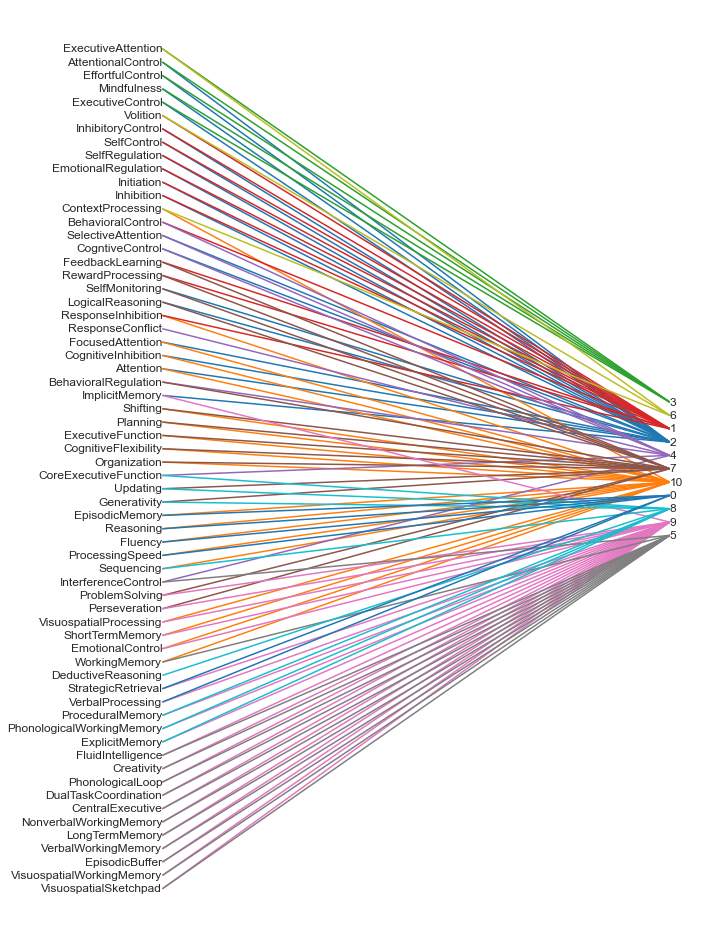

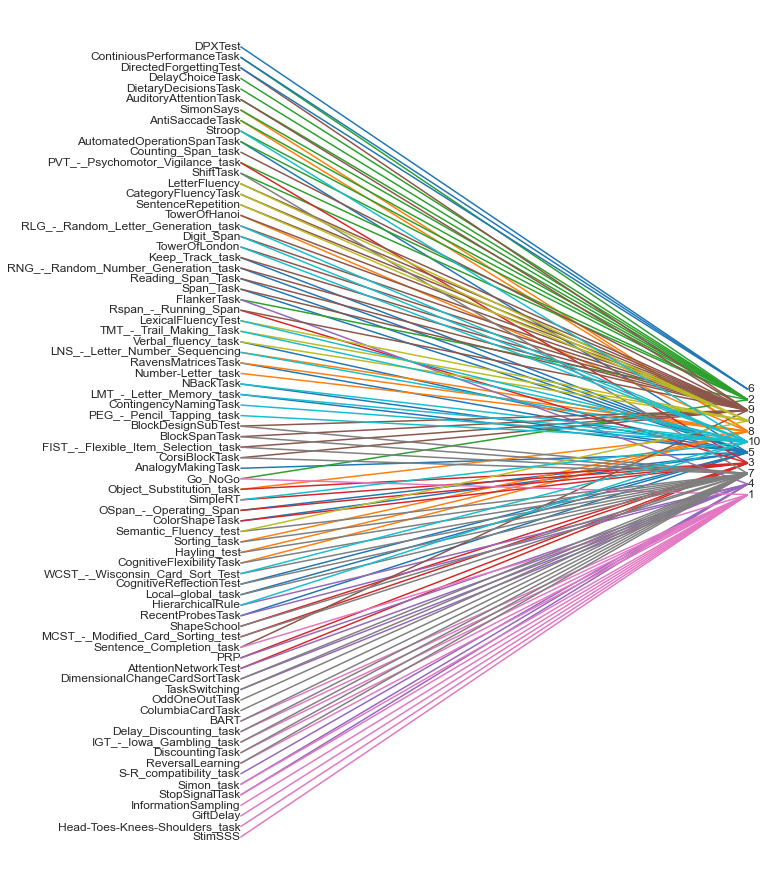

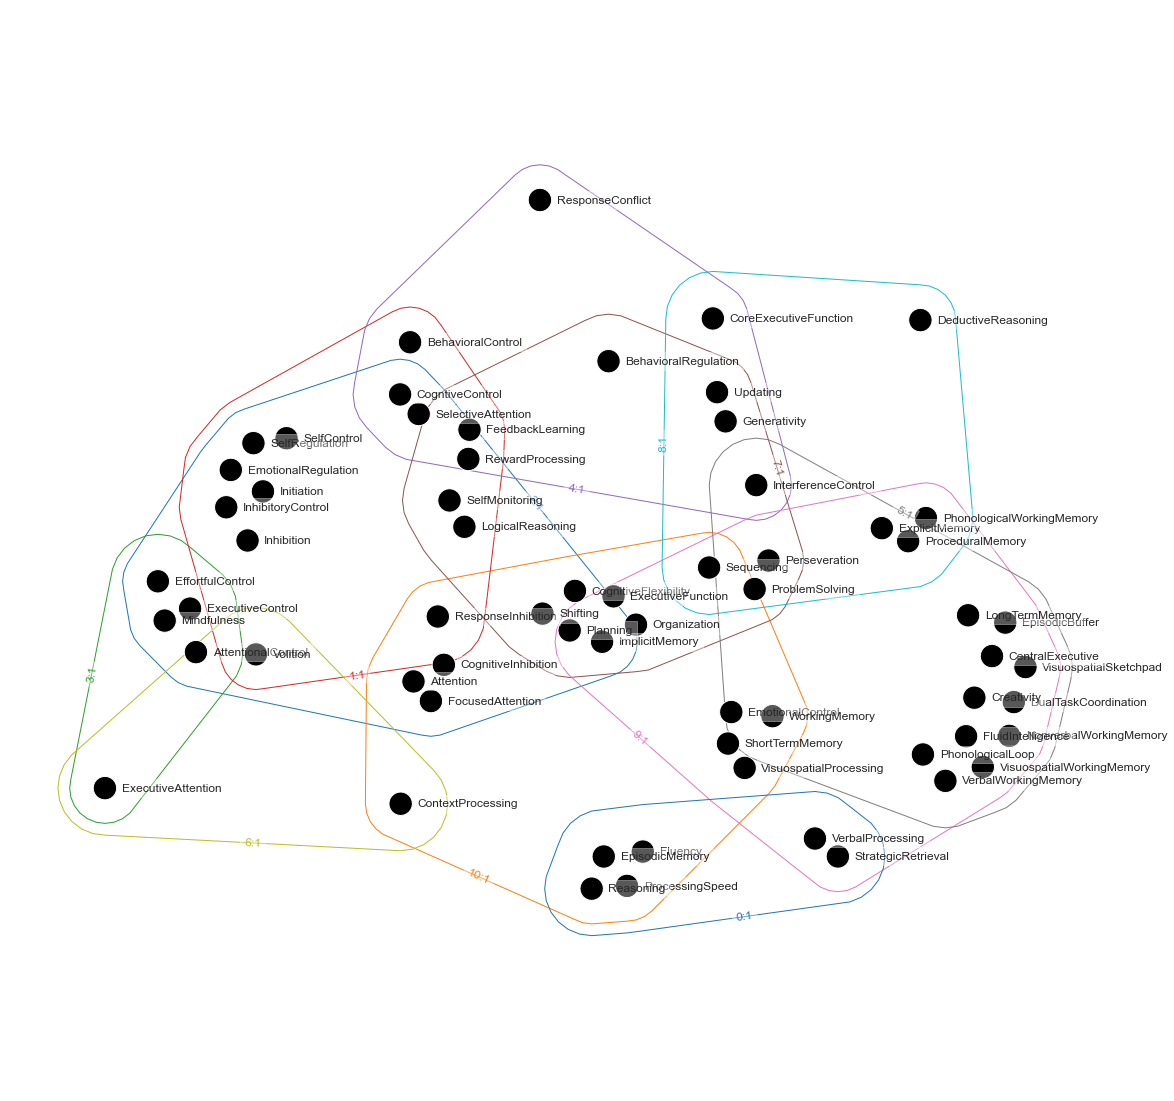

In [144]:
import hypernetx as hnx

# small size communities (non-overlapping)
C_comm_sm = C_comm.apply(lambda x: x[0:min(2,len(x))])
M_comm_sm = M_comm.apply(lambda x: x[0:min(2,len(x))])

fig, ax = plt.subplots(1,1,figsize=(10,17))
hg = hnx.Hypergraph(C_comm_sm.to_dict()).dual()
hnx.draw_two_column(hg, ax=ax)
plt.show()

fig, ax = plt.subplots(1,1,figsize=(10,16))
hg = hnx.Hypergraph(M_comm_sm.to_dict())
hnx.draw_two_column(hg.dual(), ax=ax)
plt.show()

fig, ax = plt.subplots(1,1,figsize=(20,20))
hg = hnx.Hypergraph(C_comm_sm.to_dict()).dual()
hnx.draw(hg.collapse_edges(), ax=ax, with_node_counts=True, **kwargs)
plt.show()



## Visualize 2D projection of the latent space

**WARNING: the interactive plot cannot be previewed on GitLab; open it in Google Colab or VSCode Jupyter.**

First, we simply use PCA to project the multi-dimensional latent space into a 3D space.

In [145]:
from sklearn.decomposition import PCA
import plotly.express as px

# fit PCA
pca = PCA(n_components=3)
M_pca = pd.DataFrame(pca.fit_transform(M), index=M.index).reset_index()
# M_pca['cluster'] = M_clusters.values

print('[PCA] explained variance of the tests embedding:', pca.explained_variance_ratio_)
# plot tests projection
fig = px.scatter_3d(M_pca, x=0, y=1, z=2, text='task')
fig.show()


pca = PCA(n_components=3)
C_pca = pd.DataFrame(pca.fit_transform(C), index=C.index).reset_index()
print(f'[PCA] explained variance of the constructs embedding:', pca.explained_variance_ratio_)

# plot constructs projection
fig = px.scatter_3d(C_pca, x=0, y=1, z=2, text='construct')
fig.show()

[PCA] explained variance of the tests embedding: [0.40024495 0.16301156 0.09881297]


[PCA] explained variance of the constructs embedding: [0.41678233 0.19163312 0.08173908]


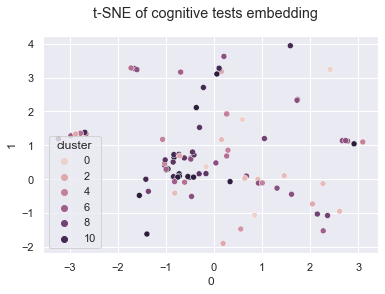

In [45]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3, verbose=0, perplexity=10, n_iter=300)
M_tsne = pd.DataFrame(tsne.fit_transform(M), index=M.index).reset_index()
M_tsne['cluster'] = M_clusters[6].values

fig = px.scatter_3d(M_tsne, x=0, y=1, z=2, color='cluster')
fig.show()

# DEBUG 2D t-SNE
tsne_2d = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=1000)
M_tsne_2d = pd.DataFrame(tsne_2d.fit_transform(M), index=M.index).reset_index()
M_tsne_2d['cluster'] = M_clusters[6].values
sns.scatterplot(data=M_tsne_2d, x=0, y=1, hue='cluster')
plt.suptitle('t-SNE of cognitive tests embedding')
plt.show()

# sns.scatterplot(
#     x="tsne-2d-one", y="tsne-2d-two",
#     hue="y",
#     palette=sns.color_palette("hls", 10),
#     data=df_subset,
#     legend="full",
#     alpha=0.3
# )

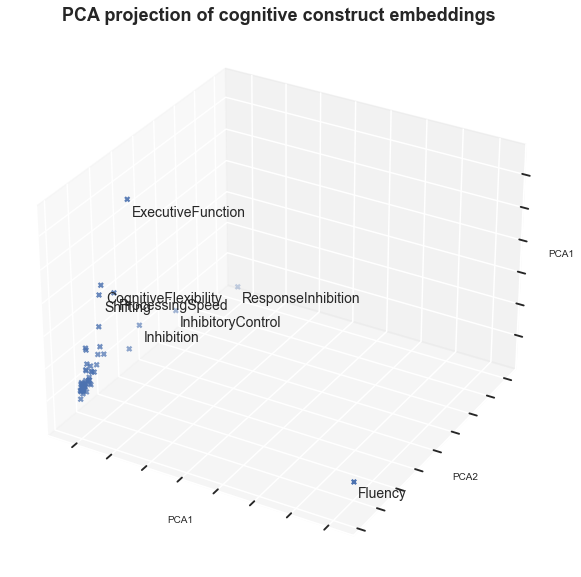

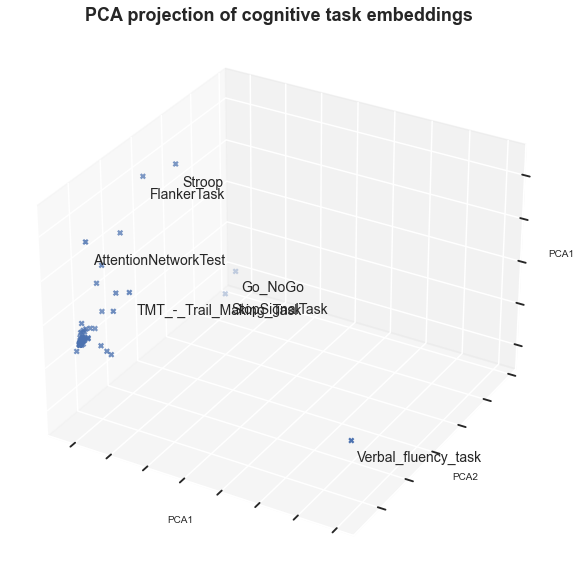

In [46]:
def plot_3d_pca(embedding):

    sns.set_theme('talk')
    pca = PCA(n_components=3)
    projections = pd.DataFrame(pca.fit_transform(embedding), index=embedding.index).reset_index()

    # 2D
    # ax = sns.scatterplot(data=projections, x=0, y=1)
    # for i, point in projections.iterrows():
    #     if np.linalg.norm(point[[0,1]].values) > .2:
    #         ax.text(point[0], point[1] + np.random.uniform(0,.05), point[embedding.index.name])
    # plt.show()

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(projection='3d')
    ax.set_facecolor('white')
    ax.scatter(projections[0], projections[1] - .01, projections[2] + .03, marker='x')

    for i, point in projections.iterrows():
        if np.linalg.norm(point[[0,1,2]].values) > .1:
            ax.text(point[0], point[1], point[2], point[embedding.index.name], fontsize=14)
    
    ax.set(xticklabels=[], yticklabels=[], zticklabels=[])
    ax.set_xlabel('PCA1', fontsize=10)
    ax.set_ylabel('PCA2', fontsize=10)
    ax.set_zlabel('PCA1', fontsize=10)

    plt.title(f'PCA projection of cognitive {embedding.index.name} embeddings', weight='bold')
    plt.savefig(OUTPUT_FOLDER / f'7_pca_3d_projection_{embedding.index.name}.png')
    plt.show()

plot_3d_pca(C)
plot_3d_pca(M)